In [1]:
#ICB_diags

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset

import xarray as xr
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40309,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:39455,Total threads: 4
Dashboard: /proxy/38209/status,Memory: 21.33 GiB
Nanny: tcp://127.0.0.1:45949,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'


# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'
# idem as GPC013 but gade line formulation
Tfreezing_min_calv_2_gade = 'accessom2-GPC015'
# idem as GPC015 plus Merino's ICB
gade_icb_v0 = 'accessom2-GPC016'
# idem as GPC015 plus Merino's ICB + 10%
gade_icb = 'accessom2-GPC018'

start_time='2150-01-01'
end_time='2151-01-01'

lat_slice  = slice(-85,-60)
fontsize=15

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/',
           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/accessom2-GPC015/',
            '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC016/accessom2-GPC016/',
           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC018/accessom2-GPC018/']
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC013


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC015


100%|██████████| 12/12 [00:03<00:00,  3.13it/s]


Indexing experiment: accessom2-GPC016


0it [00:00, ?it/s]

Indexing experiment: accessom2-GPC018



100%|██████████| 348/348 [02:02<00:00,  2.83it/s]


360

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

In [7]:
#Mass fluxes

In [41]:
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)
area_t = area_t.sel(yt_ocean=lat_slice)

In [45]:
start_time='2151-01-01'
end_time='2151-02-01'

runoff_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_gade = runoff_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_gade_x = runoff_gade_x * area_t
runoff_gade_x = runoff_gade.sum('yt_ocean').mean('time').load()
runoff_gade = runoff_gade.sum('yt_ocean').sum('xt_ocean').load()

runoff_gade_icb = cc.querying.getvar(gade_icb, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_gade_icb = runoff_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_gade_icb_x = runoff_gade_icb_x * area_t
runoff_gade_icb_x = runoff_gade_icb.sum('yt_ocean').mean('time').load()
runoff_gade_icb = runoff_gade_icb.sum('yt_ocean').sum('xt_ocean').load()

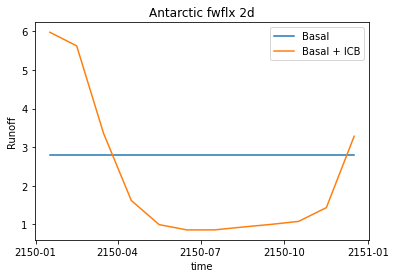

In [8]:
runoff_gade.plot(label='Basal')
runoff_gade_icb.plot(label='Basal + ICB')
plt.title('Antarctic fwflx 2d')
plt.ylabel('Runoff')
plt.legend();

(0.0, 0.04)

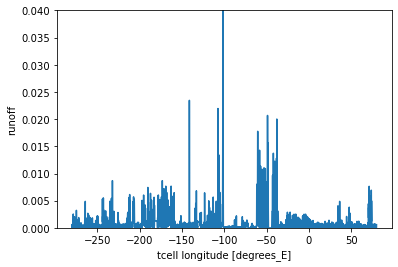

In [48]:
runoff_gade_x.plot()
plt.ylim(ymin=0,ymax=0.04)

(0.0, 0.04)

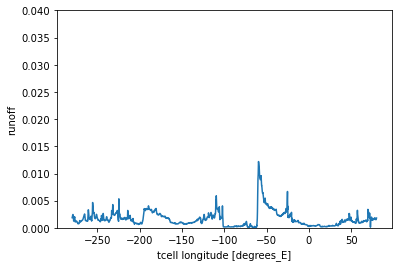

In [49]:
runoff_gade_icb_x.plot()
plt.ylim(ymin=0,ymax=0.04)

In [8]:
#Heat fluxes

In [10]:
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)
area_t = area_t.sel(yt_ocean=lat_slice)

In [12]:
start_time='2150-01-01'
end_time='2151-01-01'

hflux_runoff_con = cc.querying.getvar(control, 'sfc_hflux_from_runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
hflux_runoff_con = hflux_runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
hflux_runoff_con_W = hflux_runoff_con * area_t
hflux_runoff_con_x = hflux_runoff_con.sum('yt_ocean').load()
hflux_runoff_con_x_avet = hflux_runoff_con.sum('yt_ocean')
hflux_runoff_con_x_avet = hflux_runoff_con_x_avet.mean('time').load()
hflux_runoff_con = hflux_runoff_con.sum('yt_ocean').sum('xt_ocean').load()
hflux_runoff_con_W = hflux_runoff_con_W.sum('yt_ocean').sum('xt_ocean').load()

In [13]:
hflux_runoff_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'sfc_hflux_from_runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
hflux_runoff_gade = hflux_runoff_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
hflux_runoff_gade_W = hflux_runoff_gade * area_t
hflux_runoff_gade_x = hflux_runoff_gade.sum('yt_ocean').load()
hflux_runoff_gade_x_avet = hflux_runoff_gade.sum('yt_ocean')
hflux_runoff_gade_x_avet = hflux_runoff_gade_x_avet.mean('time').load()
hflux_runoff_gade = hflux_runoff_gade.sum('yt_ocean').sum('xt_ocean').load()
hflux_runoff_gade_W = hflux_runoff_gade_W.sum('yt_ocean').sum('xt_ocean').load()

In [14]:
hflux_runoff_gade_icb = cc.querying.getvar(gade_icb, 'sfc_hflux_from_runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
hflux_runoff_gade_icb = hflux_runoff_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
hflux_runoff_gade_icb_W = hflux_runoff_gade_icb * area_t
hflux_runoff_gade_icb_x = hflux_runoff_gade_icb.sum('yt_ocean').load()
hflux_runoff_gade_icb_x_avet = hflux_runoff_gade_icb.sum('yt_ocean')
hflux_runoff_gade_icb_x_avet = hflux_runoff_gade_icb_x_avet.mean('time').load()
hflux_runoff_gade_icb = hflux_runoff_gade_icb.sum('yt_ocean').sum('xt_ocean').load()
hflux_runoff_gade_icb_W = hflux_runoff_gade_icb_W.sum('yt_ocean').sum('xt_ocean').load()

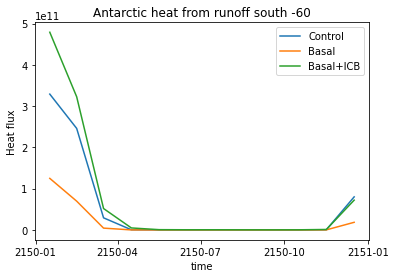

In [15]:
hflux_runoff_con_W.plot(label='Control')
hflux_runoff_gade_W.plot(label='Basal')
hflux_runoff_gade_icb_W.plot(label='Basal+ICB')
plt.title('Antarctic heat from runoff south -60')
plt.ylabel('Heat flux')
plt.legend();

In [7]:
start_time='2151-01-01'
end_time='2151-02-01'

hflux_calv_gade_icb = cc.querying.getvar(gade_icb, 'temp_hflux_runoff_gade', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
hflux_calv_gade_icb = hflux_calv_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
hflux_calv_gade_icb_x = hflux_calv_gade_icb.sum('yt_ocean').sum('st_ocean')
hflux_calv_gade_icb_x_avet = hflux_calv_gade_icb_x.mean('time').load()
hflux_calv_gade_icb = hflux_calv_gade_icb_x.sum('xt_ocean').load()
hflux_calv_gade_icb_x = hflux_calv_gade_icb_x.load()

In [8]:
hflux_basal_gade_icb = cc.querying.getvar(gade_icb, 'temp_basalmix', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
hflux_basal_gade_icb = hflux_basal_gade_icb.sel(time=slice(start_time,end_time))
hflux_basal_gade_icb_x = hflux_basal_gade_icb.sum('yt_ocean').sum('st_ocean')
hflux_basal_gade_icb_x_avet = hflux_basal_gade_icb_x.mean('time').load()
hflux_basal_gade_icb = hflux_basal_gade_icb_x.sum('xt_ocean').load()
hflux_basal_gade_icb_x = hflux_basal_gade_icb_x.load()

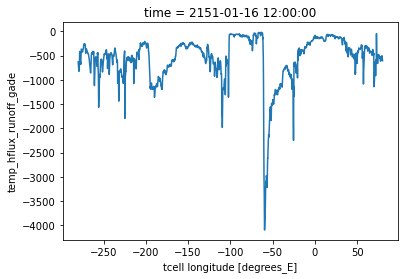

In [23]:
hflux_calv_gade_icb_x.plot()

(-4000.0, 0.0)

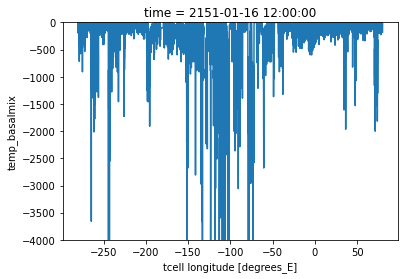

In [9]:
hflux_basal_gade_icb_x.plot()
plt.ylim(ymin=-4000,ymax=0)

In [7]:
start_time='2152-01-01'
end_time='2153-01-01'
temp_gade_icb = cc.querying.getvar(gade_icb, 'temp_runoff_gade', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_gade_icb = temp_gade_icb.sel(time=slice(start_time,end_time))
temp_gade_icb_x = temp_gade_icb.sum('yt_ocean_sub01').load()
temp_gade_icb_x_avet = temp_gade_icb.sum('yt_ocean_sub01')
temp_gade_icb_x_avet = temp_gade_icb_x_avet.mean('time').load()
temp_gade_icb = temp_gade_icb.sum('yt_ocean_sub01').sum('xt_ocean_sub01').load()

VariableNotFoundError: No files were found containing 'temp_runoff_gade' in the 'accessom2-GPC018' experiment

In [ ]:
#Surface temp

In [8]:
start_time='2152-01-01'
end_time='2153-01-01'

surface_temp_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'surface_temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
surface_temp_gade = surface_temp_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_temp_gade_sum = surface_temp_gade.mean('yt_ocean').mean('xt_ocean').load()
surface_temp_gade_ave = surface_temp_gade.mean('time')

surface_temp_gade_icb = cc.querying.getvar(gade_icb, 'surface_temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
surface_temp_gade_icb = surface_temp_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_temp_gade_icb_sum = surface_temp_gade_icb.mean('yt_ocean').mean('xt_ocean').load()
surface_temp_gade_icb_ave = surface_temp_gade_icb.mean('time')

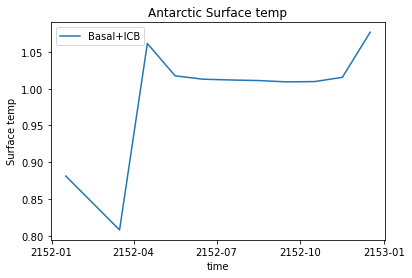

In [9]:
#surface_temp_gade_sum.plot(label='Basal')
#surface_temp_Tfreezing_min_calv_2_sum.plot(label='Tfreezing_min_calv_2')
(surface_temp_gade_icb_sum/surface_temp_gade_sum).plot(label='Basal+ICB')

plt.title('Antarctic Surface temp')
plt.ylabel('Surface temp')
plt.legend();

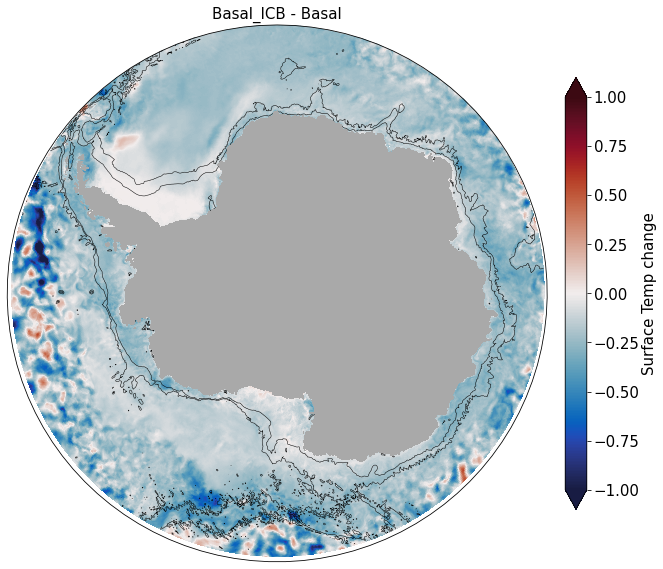

In [21]:
scale_max = 1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(surface_temp_gade.xt_ocean,surface_temp_gade.yt_ocean,surface_temp_gade_icb_ave-surface_temp_gade_ave, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_ICB - Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.31, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Surface Temp change',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [11]:
#Surface salt

In [12]:
start_time='2152-01-01'
end_time='2153-01-01'

surface_salt_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'surface_salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
surface_salt_gade = surface_salt_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_salt_gade_sum = surface_salt_gade.mean('yt_ocean').mean('xt_ocean').load()
surface_salt_gade_ave = surface_salt_gade.mean('time')

surface_salt_gade_icb = cc.querying.getvar(gade_icb, 'surface_salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
surface_salt_gade_icb = surface_salt_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_salt_gade_icb_sum = surface_salt_gade_icb.mean('yt_ocean').mean('xt_ocean').load()
surface_salt_gade_icb_ave = surface_salt_gade_icb.mean('time')

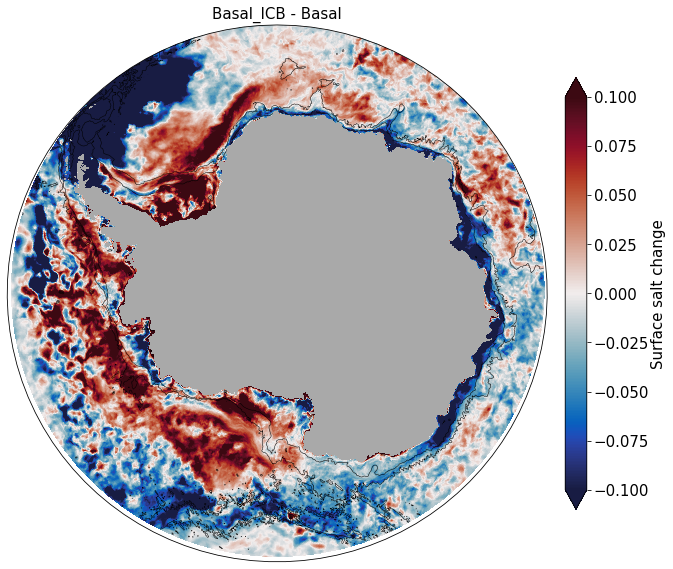

In [13]:
scale_max = .1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(surface_salt_gade.xt_ocean,surface_salt_gade.yt_ocean,surface_salt_gade_icb_ave-surface_salt_gade_ave, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_ICB - Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.31, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Surface salt change',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [14]:
#Surface age

In [15]:
start_time='2152-01-01'
end_time='2153-01-01'

age_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'age_global', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_gade = age_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

age_gade_icb = cc.querying.getvar(gade_icb, 'age_global', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_gade_icb = age_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

In [16]:
diff_age = age_gade_icb[:,1,:,:] - age_gade[:,1,:,:]
avek_diff_age = diff_age
avet_avek_diff_age = avek_diff_age.mean('time')

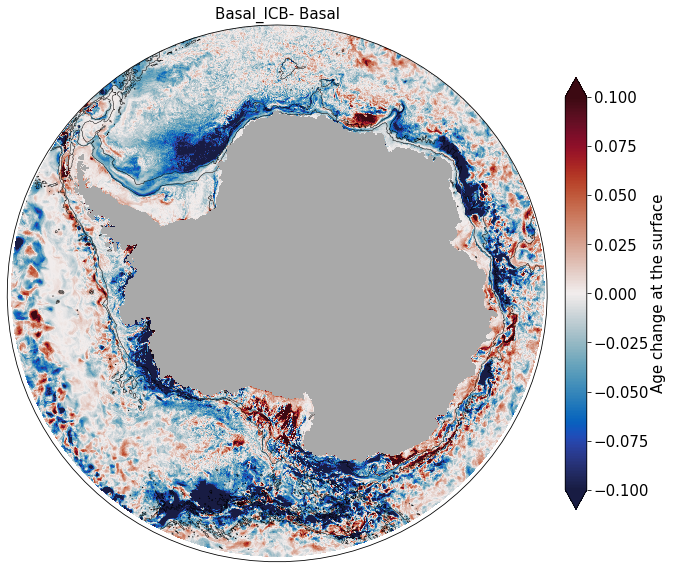

In [17]:
scale_max = 0.1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(avet_avek_diff_age.xt_ocean, avet_avek_diff_age.yt_ocean, avet_avek_diff_age, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_ICB- Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Age change at the surface',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [18]:
age_gade_avet = age_gade.mean('time')
age_gade_icb_avet = age_gade_icb.mean('time')

depth_array = age_gade_avet * 0 + age_gade_avet.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_age_gade = age_gade_avet.where(depth_array.st_ocean >= max_depth)
bottom_age_gade = bottom_age_gade.sum(dim = 'st_ocean')
bottom_age_gade = bottom_age_gade.load()

bottom_age_gade_icb = age_gade_icb_avet.where(depth_array.st_ocean >= max_depth)
bottom_age_gade_icb = bottom_age_gade_icb.sum(dim = 'st_ocean')
bottom_age_gade_icb = bottom_age_gade_icb.load()

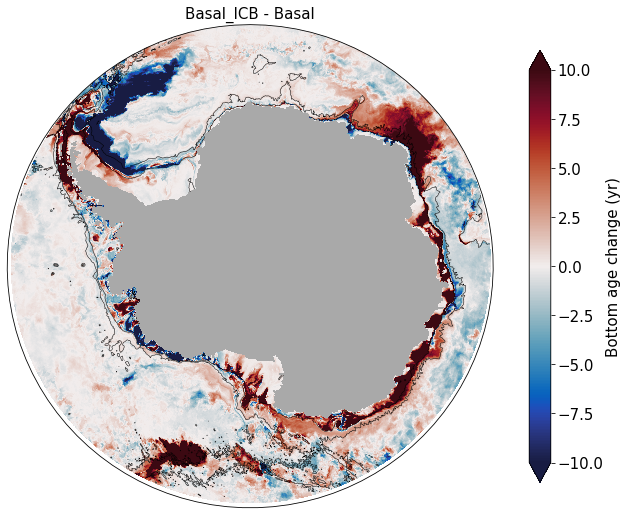

In [19]:
scale_max = 10

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=-2.4,vmax=1.5)

# Anomaly Tfreezing_min_calv_2
# setup stereo projection:
ax = fig.add_axes([0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
vmin,vmax,contourstep=-2.4,1.7,0.2
#nb_contours = np.ceil((vmax-vmin)/contourstep)
nb_contours = 20
#contours = np.arange(vmin,vmax+contourstep,contourstep)
contours = [round(x , 4) for x in np.linspace(vmin,vmax,int(nb_contours+1))]
cf1 = ax.pcolormesh(bottom_age_gade.xt_ocean, bottom_age_gade.yt_ocean, bottom_age_gade_icb - bottom_age_gade,
                   norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_ICB - Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.29, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf1, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom age change (yr)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [20]:
#Temp diff between different levels

In [22]:
start_time='2152-01-01'
end_time='2153-01-01'

temp_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_gade = temp_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

temp_gade_icb = cc.querying.getvar(gade_icb, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_gade_icb = temp_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

In [23]:
temp_gade.st_ocean[20:24]

<xarray.DataArray 'st_ocean' (st_ocean: 4)>
array([69.69342 , 78.096012, 87.379884, 97.636997])
Coordinates:
  * st_ocean  (st_ocean) float64 69.69 78.1 87.38 97.64
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean

In [24]:
temp_gade_levels = temp_gade[:,20:24,:,:]
temp_gade_icb_levels = temp_gade_icb[:,20:24,:,:]

diff_temp_gade = temp_gade_icb_levels - temp_gade_levels

In [25]:
avek_diff_temp_gade = diff_temp_gade.mean('st_ocean')
avet_avek_temp_gade = avek_diff_temp_gade.mean('time')

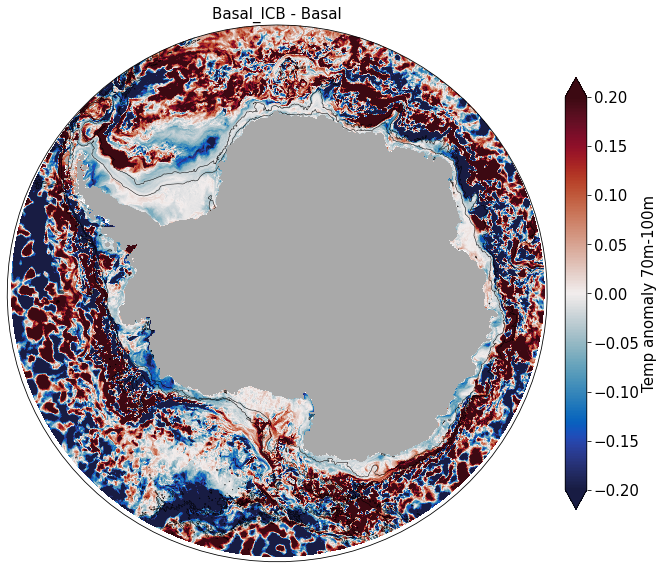

In [26]:
scale_max = .2

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(temp_gade.xt_ocean,temp_gade.yt_ocean,avet_avek_temp_gade, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_ICB - Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.31, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Temp anomaly 70m-100m',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [27]:
start_time='2152-01-01'
end_time='2153-01-01'

age_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'age_global', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_gade = age_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

age_gade_icb = cc.querying.getvar(gade_icb, 'age_global', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_gade_icb = age_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

In [28]:
age_gade_levels = age_gade[:,34:43,:,:]
age_gade_icb_levels = age_gade_icb[:,34:43,:,:]

diff_age_gade = age_gade_icb_levels - age_gade_levels
avek_diff_age_gade = diff_age_gade.mean('st_ocean')
avet_avek_age_gade = avek_diff_age_gade.mean('time')

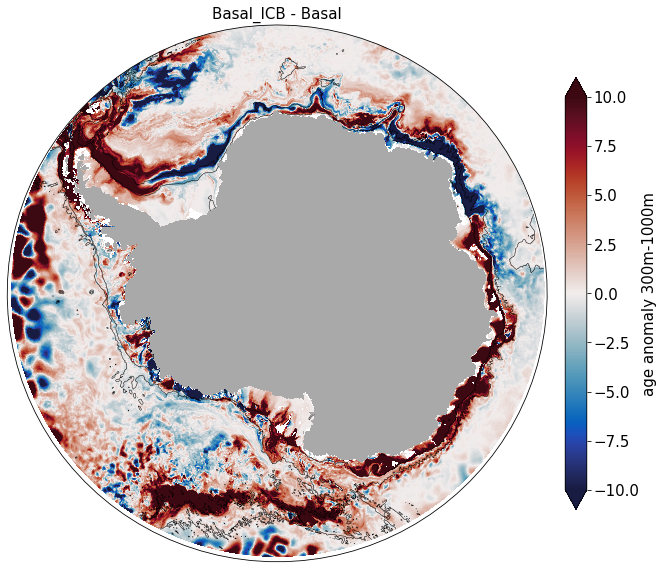

In [29]:
scale_max = 10

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(age_gade.xt_ocean,age_gade.yt_ocean,avet_avek_age_gade, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_ICB - Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.31, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'age anomaly 300m-1000m',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [30]:
start_time='2152-01-01'
end_time='2153-01-01'

salt_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_gade = salt_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

salt_gade_icb = cc.querying.getvar(gade_icb, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_gade_icb = salt_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

In [31]:
salt_gade_levels = salt_gade[:,34:43,:,:]
salt_gade_icb_levels = salt_gade_icb[:,34:43,:,:]

diff_salt_gade = salt_gade_icb_levels - salt_gade_levels
avek_diff_salt_gade = diff_salt_gade.mean('st_ocean')
avet_avek_salt_gade = avek_diff_salt_gade.mean('time')

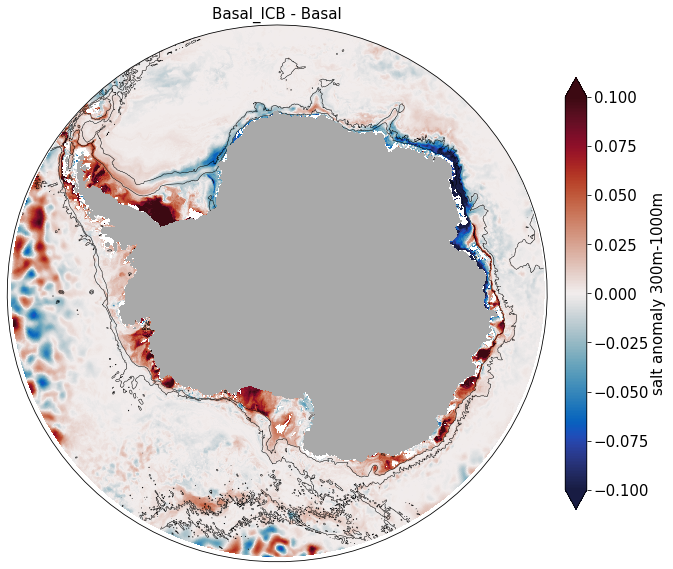

In [32]:
scale_max = 0.1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(salt_gade.xt_ocean,salt_gade.yt_ocean,avet_avek_salt_gade, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_ICB - Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.31, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'salt anomaly 300m-1000m',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [33]:
#Anomaly at the bottom

In [34]:
start_time='2152-01-01'
end_time='2153-01-01'

temp_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_gade = temp_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()
temp_gade = temp_gade.mean('time')

temp_gade_icb = cc.querying.getvar(gade_icb, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_gade_icb = temp_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()
temp_gade_icb = temp_gade_icb.mean('time')

In [35]:
# select out bottom values:

depth_array = temp_gade * 0 + temp_gade.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_gade = temp_gade.where(depth_array.st_ocean >= max_depth)
bottom_temp_gade = bottom_temp_gade.sum(dim = 'st_ocean')
bottom_temp_gade = bottom_temp_gade.load()

bottom_temp_gade_icb = temp_gade_icb.where(depth_array.st_ocean >= max_depth)
bottom_temp_gade_icb = bottom_temp_gade_icb.sum(dim = 'st_ocean')
bottom_temp_gade_icb = bottom_temp_gade_icb.load()

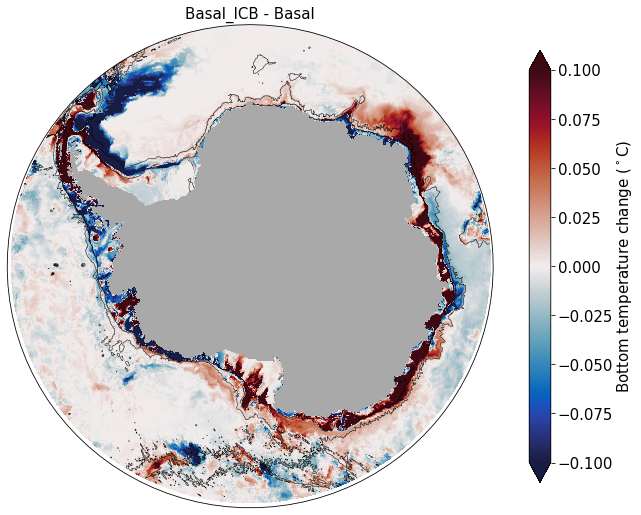

In [36]:
scale_max = .1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=-2.4,vmax=1.5)

# Anomaly Tfreezing_min_calv_2
# setup stereo projection:
ax = fig.add_axes([0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
vmin,vmax,contourstep=-2.4,1.7,0.2
#nb_contours = np.ceil((vmax-vmin)/contourstep)
nb_contours = 20
#contours = np.arange(vmin,vmax+contourstep,contourstep)
contours = [round(x , 4) for x in np.linspace(vmin,vmax,int(nb_contours+1))]
cf = ax.pcolormesh(bottom_temp_gade.xt_ocean, bottom_temp_gade.yt_ocean, bottom_temp_gade_icb - bottom_temp_gade,
                   norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_ICB - Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.29, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [40]:
start_time='2150-01-01'
end_time='2151-01-01'

salt_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_gade = salt_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()
salt_gade = salt_gade.mean('time')

salt_gade_icb = cc.querying.getvar(gade_icb, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_gade_icb = salt_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()
salt_gade_icb = salt_gade_icb.mean('time')

In [41]:
# select out bottom values:

depth_array = salt_gade * 0 + salt_gade.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_salt_gade = salt_gade.where(depth_array.st_ocean >= max_depth)
bottom_salt_gade = bottom_salt_gade.sum(dim = 'st_ocean')
bottom_salt_gade = bottom_salt_gade.load()

bottom_salt_gade_icb = salt_gade_icb.where(depth_array.st_ocean >= max_depth)
bottom_salt_gade_icb = bottom_salt_gade_icb.sum(dim = 'st_ocean')
bottom_salt_gade_icb = bottom_salt_gade_icb.load()

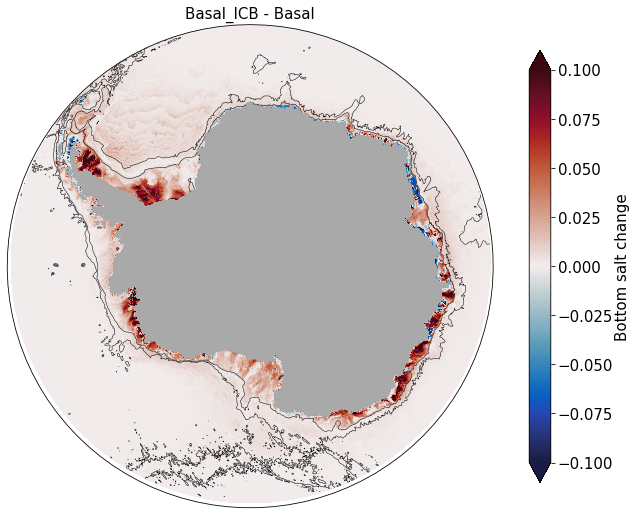

In [42]:
scale_max = .1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=-2.4,vmax=1.5)

# Anomaly Tfreezing_min_calv_2
# setup stereo projection:
ax = fig.add_axes([0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
vmin,vmax,contourstep=-2.4,1.7,0.2
#nb_contours = np.ceil((vmax-vmin)/contourstep)
nb_contours = 20
#contours = np.arange(vmin,vmax+contourstep,contourstep)
contours = [round(x , 4) for x in np.linspace(vmin,vmax,int(nb_contours+1))]
cf = ax.pcolormesh(bottom_salt_gade.xt_ocean, bottom_salt_gade.yt_ocean, bottom_salt_gade_icb - bottom_salt_gade,
                   norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_ICB - Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.29, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom salt change',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)